In [57]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit, lax, grad
import matplotlib.pyplot as plt
import cmocean as cmo
import importlib
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from jax.config import config
config.update("jax_enable_x64", True)

import warnings
warnings.filterwarnings("always")

from bbmm.utils import test_modules, calc_loss_dloss, calc_prediction
import bbmm.utils.preconditioner as precond
import bbmm.functions.pivoted_cholesky_jax as pc_jax
import bbmm.operators.diag_linear_operator as diag_linear_operator
import bbmm.operators.psd_sum_linear_operator as  psd_sum_linear_operator
import bbmm.operators.root_linear_operator as root_linear_operator

importlib.reload(test_modules)
importlib.reload(psd_sum_linear_operator)
importlib.reload(diag_linear_operator)
importlib.reload(root_linear_operator)
importlib.reload(precond)
importlib.reload(calc_prediction)

from stopro.sub_modules.load_modules import load_params, load_data
from stopro.sub_modules.loss_modules import hessian, logposterior
from stopro.sub_modules.init_modules import get_init, reshape_init
import stopro.GP.gp_1D_naive as gp_1D_naive
from stopro.data_handler.data_handle_module import HdfOperator
from stopro.GP.kernels import define_kernel
import stopro.solver.optimizers as optimizers
importlib.reload(optimizers)

<module 'stopro.solver.optimizers' from '/home/ogawa_kenta/opt/stopro/solver/optimizers.py'>

In [2]:
project_name = 'data'
simulation_name = 'test_loss_sin1d_naive'
params_main, params_prepare, lbls = load_params(f"{project_name}/{simulation_name}/data_input")
params_model = params_main["model"]
params_optimization = params_main["optimization"]
params_plot = params_prepare["plot"]
vnames = params_prepare["vnames"]
params_setting = params_prepare["setting"]
params_generate_training = params_prepare["generate_training"]
params_generate_test = params_prepare["generate_test"]
params_kernel_arg = params_prepare["kernel_arg"]

# prepare initial hyper-parameter
init = get_init(
    params_model["init_kernel_hyperparameter"],
    params_model["kernel_type"],
    system_type=params_model["system_type"],
)

In [3]:
# prepare data
hdf_operator = HdfOperator(f"{project_name}/{simulation_name}")
r_test, μ_test, r_train, μ_train, f_train = load_data(lbls, vnames, hdf_operator)
delta_y_train = jnp.empty(0)
for i in range(len(r_train)):
    delta_y_train = jnp.append(delta_y_train, f_train[i] - μ_train[i])

params_model["epsilon"] = 1e-06
args_predict = r_test, μ_test, r_train, delta_y_train, params_model["epsilon"]
noise = params_model["epsilon"]
r_test, f_test = hdf_operator.load_test_data(lbls['test'], vnames['test'])

In [4]:
# setup model
Kernel = define_kernel(params_model)
gp_model = gp_1D_naive.GPmodel1DNaive(
    Kernel=Kernel,
)
gp_model.set_constants(*args_predict)
loglikelihood, predictor = (
    gp_model.trainingFunction_all,
    gp_model.predictingFunction_all,
)
func = jit(logposterior(loglikelihood, params_optimization))
dfunc = jit(grad(func, 0))
hess = hessian(func)

_K = gp_model.trainingK_all(init, r_train)
K = gp_model.add_eps_to_sigma(_K, noise)
test_modules.is_positive_definite(K), test_modules.check_cond(K)

2.20e+03


(True, Array(2196.3286535, dtype=float64))

## without precondition

In [5]:
func_value_grad_mpcg = calc_loss_dloss.setup_loss_dloss_mpcg(
    rank=5,
    n_tridiag=20,
    max_tridiag_iter=20,
    cg_tolerance=1,
    gp_model=gp_model,
)

In [6]:
params_optimization["maxiter_scipy"] = [0]
params_optimization["maxiter_GD"] = 5
params_optimization["use_explicit_derivative_for_adam"] = True
params_optimization["eps"] = 1e-3

In [7]:
# setup model
Kernel = define_kernel(params_model)
gp_model = gp_1D_naive.GPmodel1DNaive(
    Kernel=Kernel,
)
gp_model.set_constants(*args_predict)
loglikelihood, predictor = (
    gp_model.trainingFunction_all,
    gp_model.predictingFunction_all,
)
func = jit(logposterior(loglikelihood, params_optimization))
dfunc = jit(grad(func, 0))
hess = hessian(func)

In [8]:
opt, loss, theta, norm_of_grads_list = optimizers.optimize_by_adam(
    func, dfunc, hess, init, params_optimization, *args_predict[2:]
)

loss before optimize: 0.2572682692243714
step   0 loss: 0.2573 max_grad: 1.68969, arg=1
norm_of_grads: 1.75214
[-0.01  0.01]
step   1 loss: 0.2356 max_grad: 1.71122, arg=1
norm_of_grads: 1.77223
[-0.02  0.02]
step   2 loss: 0.2138 max_grad: 1.73250, arg=1
norm_of_grads: 1.79207
[-0.03  0.03]
step   3 loss: 0.1918 max_grad: 1.75350, arg=1
norm_of_grads: 1.81166
[-0.04  0.04]
step   4 loss: 0.1696 max_grad: 1.77422, arg=1
norm_of_grads: 1.83099
[-0.05    0.0501]


In [9]:
opt, loss, theta, norm_of_grads_list = optimizers.optimize_by_adam(func_value_grad_mpcg, None, None, init, params_optimization, *args_predict[2:])

loss before optimize: 0.34610145040243073
step   0 loss: 0.3461 max_grad: 1.59760, arg=1
norm_of_grads: 1.66243
[-0.01  0.01]
step   1 loss: 0.3252 max_grad: 1.62107, arg=1
norm_of_grads: 1.68387
[-0.02  0.02]
step   2 loss: 0.3042 max_grad: 1.64441, arg=1
norm_of_grads: 1.70516
[-0.03  0.03]
step   3 loss: 0.2829 max_grad: 1.66760, arg=1
norm_of_grads: 1.72601
[-0.04  0.04]
step   4 loss: 0.2613 max_grad: 1.69064, arg=1
norm_of_grads: 1.74747
[-0.05    0.0501]


In [10]:
params_optimization["maxiter_scipy"] = [0]
params_optimization["maxiter_GD"] = 1000
params_optimization["use_explicit_derivative_for_adam"] = True

In [11]:
opt, loss, theta, norm_of_grads_list = optimizers.optimize_by_adam(
    func, dfunc, hess, init, params_optimization, *args_predict[2:]
)

loss before optimize: 0.2572682692243714
step   0 loss: 0.2573 max_grad: 1.68969, arg=1
norm_of_grads: 1.75214
[-0.01  0.01]
step   1 loss: 0.2356 max_grad: 1.71122, arg=1
norm_of_grads: 1.77223
[-0.02  0.02]
step   2 loss: 0.2138 max_grad: 1.73250, arg=1
norm_of_grads: 1.79207
[-0.03  0.03]
step   3 loss: 0.1918 max_grad: 1.75350, arg=1
norm_of_grads: 1.81166
[-0.04  0.04]
step   4 loss: 0.1696 max_grad: 1.77422, arg=1
norm_of_grads: 1.83099
[-0.05    0.0501]
step   5 loss: 0.1472 max_grad: 1.79465, arg=1
norm_of_grads: 1.85003
[-0.06    0.0601]
step   6 loss: 0.1246 max_grad: 1.81478, arg=1
norm_of_grads: 1.86879
[-0.0699  0.0701]
step   7 loss: 0.1019 max_grad: 1.83459, arg=1
norm_of_grads: 1.88724
[-0.0799  0.0802]
step   8 loss: 0.0789 max_grad: 1.85408, arg=1
norm_of_grads: 1.90538
[-0.0898  0.0903]
step   9 loss: 0.0558 max_grad: 1.87323, arg=1
norm_of_grads: 1.92320
[-0.0998  0.1004]
step  10 loss: 0.0325 max_grad: 1.89203, arg=1
norm_of_grads: 1.94068
[-0.1097  0.1105]
step  1

In [12]:
opt_mpcg, loss_mpcg, theta_mpcg, norm_of_grads_list_mpcg = optimizers.optimize_by_adam(func_value_grad_mpcg, None, None, init, params_optimization, *args_predict[2:])

loss before optimize: 0.34610145040243073
step   0 loss: 0.3461 max_grad: 1.59760, arg=1
norm_of_grads: 1.66243
[-0.01  0.01]
step   1 loss: 0.3252 max_grad: 1.62107, arg=1
norm_of_grads: 1.68387
[-0.02  0.02]
step   2 loss: 0.3042 max_grad: 1.64441, arg=1
norm_of_grads: 1.70516
[-0.03  0.03]
step   3 loss: 0.2829 max_grad: 1.66760, arg=1
norm_of_grads: 1.72601
[-0.04  0.04]
step   4 loss: 0.2613 max_grad: 1.69064, arg=1
norm_of_grads: 1.74747
[-0.05    0.0501]
step   5 loss: 0.2396 max_grad: 1.71352, arg=1
norm_of_grads: 1.76858
[-0.0599  0.0601]
step   6 loss: 0.2176 max_grad: 1.73637, arg=1
norm_of_grads: 1.78990
[-0.0699  0.0702]
step   7 loss: 0.1954 max_grad: 1.75894, arg=1
norm_of_grads: 1.81047
[-0.0798  0.0802]
step   8 loss: 0.1730 max_grad: 1.78132, arg=1
norm_of_grads: 1.83082
[-0.0898  0.0903]
step   9 loss: 0.1504 max_grad: 1.80357, arg=1
norm_of_grads: 1.85158
[-0.0997  0.1004]
step  10 loss: 0.1275 max_grad: 1.82553, arg=1
norm_of_grads: 1.87208
[-0.1096  0.1105]
step  

<>:16: DeprecationWarning: invalid escape sequence '\e'
<>:16: DeprecationWarning: invalid escape sequence '\e'
/tmp/ipykernel_1752479/305494456.py:16: DeprecationWarning: invalid escape sequence '\e'
  axs[1][0].set_title('$\eta$')


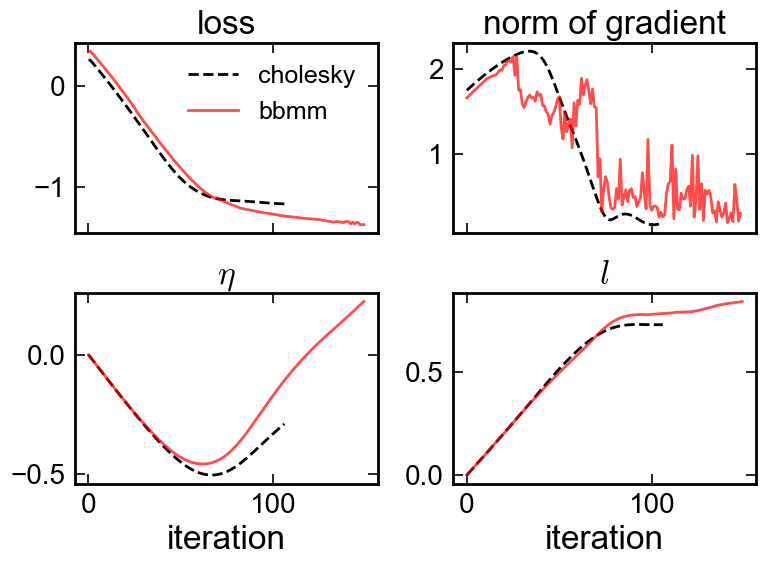

In [13]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8, 6), sharex=True)
kwargs = {"linestyle": "--"}
kwargs_mpcg = {"alpha": 0.7}

axs[0][0].plot(loss, **kwargs, label='cholesky')
axs[0][0].plot(loss_mpcg, label='bbmm', **kwargs_mpcg)
axs[0][0].set_title('loss')

axs[0][1].plot(norm_of_grads_list, **kwargs, label='default')
axs[0][1].plot(norm_of_grads_list_mpcg, label='mPCG', **kwargs_mpcg)
axs[0][1].set_title('norm of gradient')

                    
axs[1][0].plot(np.array(theta)[:, 0], **kwargs)
axs[1][0].plot(np.array(theta_mpcg)[:, 0], **kwargs_mpcg)
axs[1][0].set_title('$\eta$')
axs[1][0].set_xlabel('iteration')

axs[1][1].plot(np.array(theta)[:, 1], **kwargs)
axs[1][1].plot(np.array(theta_mpcg)[:, 1], **kwargs_mpcg)
axs[1][1].set_title('$l$')
axs[1][1].set_xlabel('iteration')

axs[0][0].legend()
plt.tight_layout()

In [58]:
predictor_mpcg = calc_prediction.setup_predictor_mpcg(gp_model=gp_model, tolerance=0.0001)
f_infer_mpcg, Sigma_mpcg = predictor_mpcg(opt_mpcg, *args_predict)
std_mpcg = jnp.sqrt(jnp.diag(Sigma_mpcg[0]))

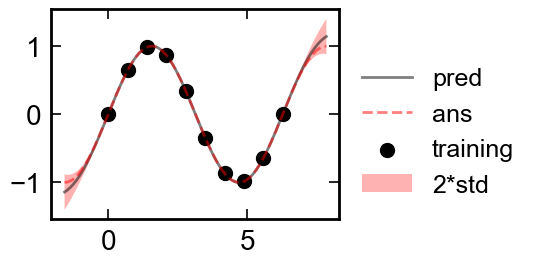

In [19]:
fs, Σs = predictor(opt, *args_predict)
std = np.sqrt(np.diag(Σs[0]))
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(r_test[0], fs[0], alpha=0.5, label='pred')
ax.plot(r_test[0], f_test[0], alpha=0.5, linestyle='--', label='ans')
ax.scatter(r_train[0], f_train[0], label='training')
ax.fill_between(r_test[0], fs[0]-std*2, fs[0]+std*2, alpha=0.3, label='2*std')
ax.legend(loc='lower left', bbox_to_anchor=(1., 0.))

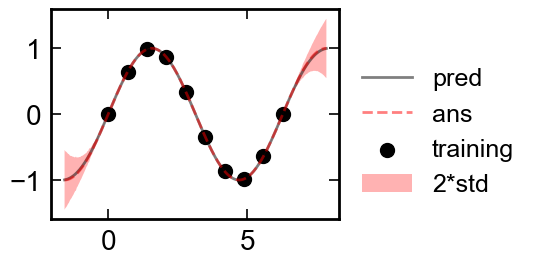

In [59]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(r_test[0], f_infer_mpcg[0], alpha=0.5, label='pred')
ax.plot(r_test[0], f_test[0], alpha=0.5, linestyle='--', label='ans')
ax.scatter(r_train[0], f_train[0], label='training')
ax.fill_between(r_test[0], f_infer_mpcg[0]-std_mpcg*2, f_infer_mpcg[0]+std_mpcg*2, alpha=0.3, label='2*std')
ax.legend(loc='lower left', bbox_to_anchor=(1., 0.))
plt.show()

## with precondition (full rank 10)

In [41]:
func_value_grad_mpcg = calc_loss_dloss.setup_loss_dloss_mpcg(
    rank=10,
    n_tridiag=20,
    max_tridiag_iter=20,
    cg_tolerance=1,
    gp_model=gp_model,
    min_preconditioning_size=1,
)

In [42]:
params_optimization["eps"] = 1e-2
opt_mpcg, loss_mpcg, theta_mpcg, norm_of_grads_list_mpcg = optimizers.optimize_by_adam(func_value_grad_mpcg, None, None, init, params_optimization, *args_predict[2:])

loss before optimize: 0.25728859707873014
step   0 loss: 0.2573 max_grad: 1.68922, arg=1
norm_of_grads: 1.75168
[-0.01  0.01]
step   1 loss: 0.2357 max_grad: 1.71068, arg=1
norm_of_grads: 1.77169
[-0.02  0.02]
step   2 loss: 0.2138 max_grad: 1.73187, arg=1
norm_of_grads: 1.79145
[-0.03  0.03]
step   3 loss: 0.1918 max_grad: 1.75278, arg=1
norm_of_grads: 1.81095
[-0.04  0.04]
step   4 loss: 0.1696 max_grad: 1.77339, arg=1
norm_of_grads: 1.83016
[-0.05    0.0501]
step   5 loss: 0.1473 max_grad: 1.79369, arg=1
norm_of_grads: 1.84908
[-0.06    0.0601]
step   6 loss: 0.1247 max_grad: 1.81368, arg=1
norm_of_grads: 1.86770
[-0.0699  0.0701]
step   7 loss: 0.1019 max_grad: 1.83330, arg=1
norm_of_grads: 1.88597
[-0.0799  0.0802]
step   8 loss: 0.0790 max_grad: 1.85258, arg=1
norm_of_grads: 1.90390
[-0.0898  0.0903]
step   9 loss: 0.0558 max_grad: 1.87149, arg=1
norm_of_grads: 1.92148
[-0.0998  0.1004]
step  10 loss: 0.0325 max_grad: 1.89002, arg=1
norm_of_grads: 1.93868
[-0.1097  0.1105]
step  

<>:16: DeprecationWarning: invalid escape sequence '\e'
<>:16: DeprecationWarning: invalid escape sequence '\e'
/tmp/ipykernel_1752479/305494456.py:16: DeprecationWarning: invalid escape sequence '\e'
  axs[1][0].set_title('$\eta$')


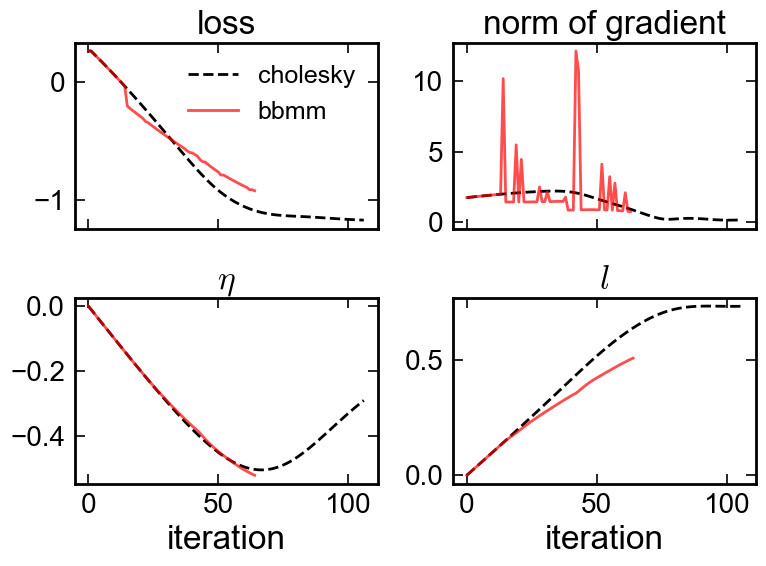

In [43]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8, 6), sharex=True)
kwargs = {"linestyle": "--"}
kwargs_mpcg = {"alpha": 0.7}

axs[0][0].plot(loss, **kwargs, label='cholesky')
axs[0][0].plot(loss_mpcg, label='bbmm', **kwargs_mpcg)
axs[0][0].set_title('loss')

axs[0][1].plot(norm_of_grads_list, **kwargs, label='default')
axs[0][1].plot(norm_of_grads_list_mpcg, label='mPCG', **kwargs_mpcg)
axs[0][1].set_title('norm of gradient')

                    
axs[1][0].plot(np.array(theta)[:, 0], **kwargs)
axs[1][0].plot(np.array(theta_mpcg)[:, 0], **kwargs_mpcg)
axs[1][0].set_title('$\eta$')
axs[1][0].set_xlabel('iteration')

axs[1][1].plot(np.array(theta)[:, 1], **kwargs)
axs[1][1].plot(np.array(theta_mpcg)[:, 1], **kwargs_mpcg)
axs[1][1].set_title('$l$')
axs[1][1].set_xlabel('iteration')

axs[0][0].legend()
plt.tight_layout()

In [44]:
predictor_mpcg = calc_prediction.setup_predictor_mpcg(gp_model=gp_model, tolerance=0.001, rank=10,  min_preconditioning_size=1)
f_infer_mpcg, Sigma_mpcg = predictor_mpcg(opt_mpcg, *args_predict)
std_mpcg = jnp.sqrt(jnp.diag(Sigma_mpcg[0]))

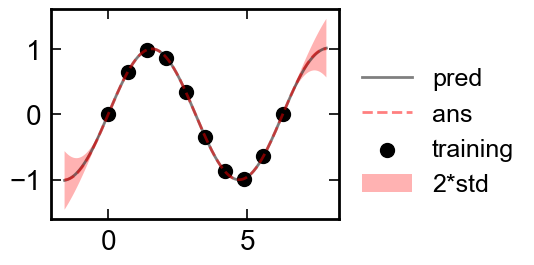

In [45]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(r_test[0], f_infer_mpcg[0], alpha=0.5, label='pred')
ax.plot(r_test[0], f_test[0], alpha=0.5, linestyle='--', label='ans')
ax.scatter(r_train[0], f_train[0], label='training')
ax.fill_between(r_test[0], f_infer_mpcg[0]-std_mpcg*2, f_infer_mpcg[0]+std_mpcg*2, alpha=0.3, label='2*std')
ax.legend(loc='lower left', bbox_to_anchor=(1., 0.))
plt.show()

## with precondition (rank = 5)

In [96]:
func_value_grad_mpcg = setup_loss_dloss_mpcg(rank=5, n_tridiag=20, max_tridiag_iter=20, cg_tolerance=1, min_preconditioning_size=1)
params_optimization["eps"] = 1e-3
opt_mpcg, loss_mpcg, theta_mpcg, norm_of_grads_list_mpcg = optimizers.optimize_by_adam(func_value_grad_mpcg, None, None, init, params_optimization, *args_predict[2:])

[   2.1361866  -180.18731844]
loss before optimize: 0.1448721214879945
[   2.1361866  -180.18731844]
step   0 loss: 0.1449 max_grad: 18.01873, arg=1
norm_of_grads: 18.02000
[-0.01  0.01]
[   2.10971789 -169.35503289]
step   1 loss: 0.1267 max_grad: 16.93550, arg=1
norm_of_grads: 16.93682
[-0.02  0.02]
[   2.08222782 -158.88524543]
step   2 loss: 0.1083 max_grad: 15.88852, arg=1
norm_of_grads: 15.88989
[-0.03    0.0299]
[   2.05370893 -148.79692124]
step   3 loss: 0.0899 max_grad: 14.87969, arg=1
norm_of_grads: 14.88111
[-0.04    0.0398]
[   2.02415996 -139.10626678]
step   4 loss: 0.0713 max_grad: 13.91063, arg=1
norm_of_grads: 13.91210
[-0.0499  0.0496]
[   1.9935863  -129.82651774]
step   5 loss: 0.0526 max_grad: 12.98265, arg=1
norm_of_grads: 12.98418
[-0.0599  0.0594]
[   1.96200049 -120.96778709]
step   6 loss: 0.0340 max_grad: 12.09678, arg=1
norm_of_grads: 12.09837
[-0.0698  0.069 ]
[   1.92942245 -112.53697832]
step   7 loss: 0.0153 max_grad: 11.25370, arg=1
norm_of_grads: 11.2

<>:16: DeprecationWarning: invalid escape sequence '\e'
<>:16: DeprecationWarning: invalid escape sequence '\e'
/tmp/ipykernel_1420304/305494456.py:16: DeprecationWarning: invalid escape sequence '\e'
  axs[1][0].set_title('$\eta$')


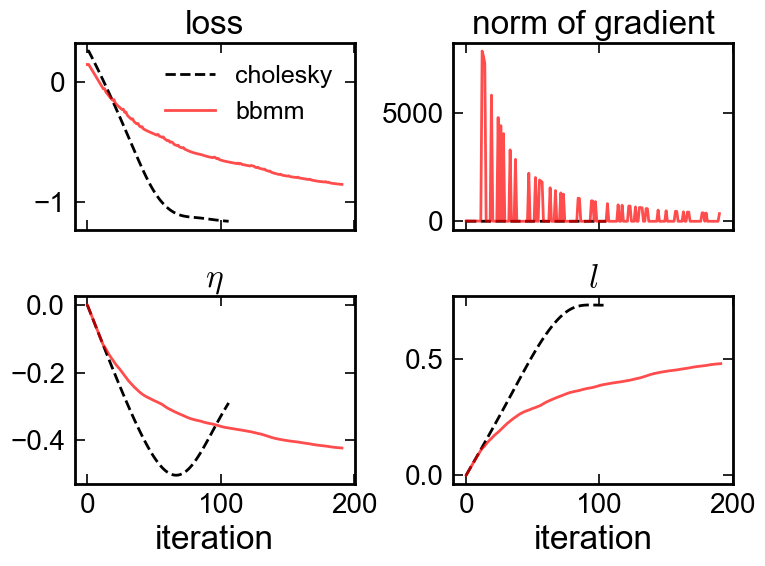

In [100]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8, 6), sharex=True)
kwargs = {"linestyle": "--"}
kwargs_mpcg = {"alpha": 0.7}

axs[0][0].plot(loss, **kwargs, label='cholesky')
axs[0][0].plot(loss_mpcg, label='bbmm', **kwargs_mpcg)
axs[0][0].set_title('loss')

axs[0][1].plot(norm_of_grads_list, **kwargs, label='default')
axs[0][1].plot(norm_of_grads_list_mpcg, label='mPCG', **kwargs_mpcg)
axs[0][1].set_title('norm of gradient')

                    
axs[1][0].plot(np.array(theta)[:, 0], **kwargs)
axs[1][0].plot(np.array(theta_mpcg)[:, 0], **kwargs_mpcg)
axs[1][0].set_title('$\eta$')
axs[1][0].set_xlabel('iteration')

axs[1][1].plot(np.array(theta)[:, 1], **kwargs)
axs[1][1].plot(np.array(theta_mpcg)[:, 1], **kwargs_mpcg)
axs[1][1].set_title('$l$')
axs[1][1].set_xlabel('iteration')

axs[0][0].legend()
plt.tight_layout()

(300, 1)


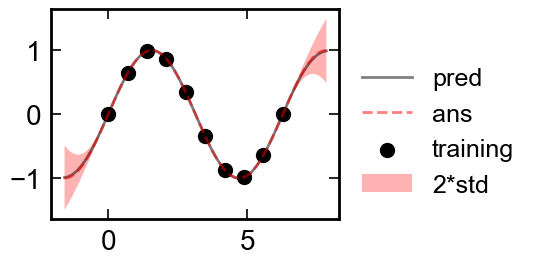

In [101]:
predictor_mpcg = setup_predictor_mpcg(min_preconditioning_size=1, rank=5)
# predictor_mpcg = setup_predictor_mpcg()
f_infer_mpcg, Sigma_mpcg = predictor_mpcg(opt_mpcg, *args_predict)
std_mpcg = jnp.sqrt(jnp.diag(Sigma_mpcg))

fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(r_test[0], f_infer_mpcg[0], alpha=0.5, label='pred')
ax.plot(r_test[0], f_test[0], alpha=0.5, linestyle='--', label='ans')
ax.scatter(r_train[0], f_train[0], label='training')
ax.fill_between(r_test[0], f_infer_mpcg[0]-std_mpcg*2, f_infer_mpcg[0]+std_mpcg*2, alpha=0.3, label='2*std')
ax.legend(loc='lower left', bbox_to_anchor=(1., 0.))
plt.show()

In [234]:
func_value_grad_mpcg = setup_loss_dloss_mpcg(rank=5, n_tridiag=20, max_tridiag_iter=40, cg_tolerance=0.01, min_preconditioning_size=1)

In [235]:
func_value_grad_mpcg(init, *args_predict[2:])

[   2.13618592 -180.83632998]


(Array(0.14487212, dtype=float64),
 Array([  0.21361859, -18.083633  ], dtype=float64))

In [236]:
func(init, *args_predict[2:])/len(K), gp_model.d_logposterior(init, *args_predict[2:])/len(K)

(Array(0.25726827, dtype=float64),
 Array([ 0.56363759, -1.58968953], dtype=float64))

In [87]:
precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=10, noise=noise, min_preconditioning_size=1)

In [88]:
precondition(jnp.eye(10))[0]

Array([  7.81569088, -15.67781471,  19.32716081, -19.06075518,
        16.47753277, -12.91012286,   9.16777001,  -5.70692588,
         2.84227658,  -0.87003169], dtype=float64)

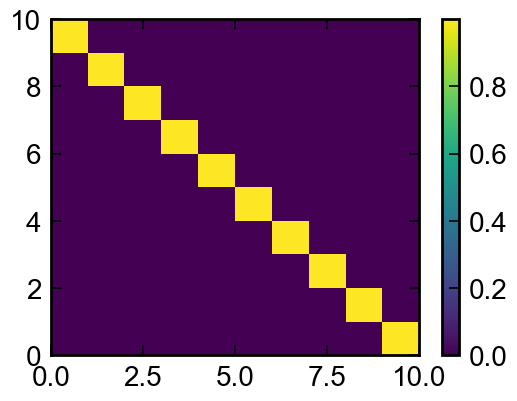

In [89]:
# plt.pcolormesh(np.flipud(precondition(K)))
# plt.colorbar()
# plt.pcolormesh(np.flipud(K))
# plt.colorbar()

## calculating $\mathrm{tr}(\hat{\bm{P}}^{-1}\frac{\partial \hat{\bm{P}}}{\partial\theta})$

In [251]:
rank=10
n_tridiag=10
seed=0
cg_tolerance=0.01
max_tridiag_iter=20
min_preconditioning_size=1
max_iter_cg=1000

r = r_train
delta_y = delta_y_train
zs = jax.random.normal(jax.random.PRNGKey(seed), (len(delta_y), n_tridiag))

In [252]:
## explicit way
K = gp_model.trainingK_all(init, r)
K = gp_model.add_eps_to_sigma(K, noise, noise_parameter=None)
precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank, noise=noise, min_preconditioning_size=min_preconditioning_size)
def calc_dP(theta):
    K = gp_model.trainingK_all(theta, r)
    K = gp_model.add_eps_to_sigma(K, noise, noise_parameter=None)
    _, precond_lt, _ = precond.setup_preconditioner(K, rank=rank, noise=noise, min_preconditioning_size=min_preconditioning_size, func_pivoted_cholesky=pc_jax.pivoted_cholesky_jax)
    return precond_lt.matmul(jnp.eye(len(K)))
# PinvdPz = precondition(jnp.transpose(jax.jacfwd(Pz)(init), (2, 0, 1)))
dP = jnp.transpose(jax.jacfwd(calc_dP)(init), (2, 0, 1))

In [253]:
trace_P_direct = jnp.sum(jnp.diagonal(precondition(dP), axis1=-2, axis2=-1), axis=-1)

In [254]:
precond_lt._diagonal()

Array([1.000002, 1.000002, 1.000002, 1.000002, 1.000002, 1.000002,
       1.000002, 1.000002, 1.000002, 1.000002], dtype=float64)

In [255]:
left_term = precond_lt.left_term_of_trace()

In [256]:
def diagonal_dP(theta):
    K = gp_model.trainingK_all(theta, r)
    K = gp_model.add_eps_to_sigma(K, noise, noise_parameter=None)
    _, precond_lt, _ = precond.setup_preconditioner(K, rank=rank, noise=noise, min_preconditioning_size=min_preconditioning_size, func_pivoted_cholesky=pc_jax.pivoted_cholesky_jax)
    return precond_lt._diagonal()
diag_dP = jnp.transpose(jax.jacfwd(diagonal_dP)(init), (1, 0))

In [257]:
def Poperand(theta, operand):
    K = gp_model.trainingK_all(theta, r)
    K = gp_model.add_eps_to_sigma(K, noise, noise_parameter=None)
    _, precond_lt, _ = precond.setup_preconditioner(K, rank=rank, noise=noise, min_preconditioning_size=min_preconditioning_size, func_pivoted_cholesky=pc_jax.pivoted_cholesky_jax)
    return precond_lt.matmul(operand)
dPL = jnp.transpose(jax.jacfwd(Poperand, 0)(init, precond_lt.linear_ops[0].root.array), (2, 0, 1))

In [258]:
trace_P_woodbury = (jnp.sum(diag_dP, axis=-1) - jnp.sum(jnp.multiply(left_term, dPL), axis=(-2, -1))) / noise

In [259]:
trace_P_direct, trace_P_woodbury

(Array([  9.99834645, -38.24928121], dtype=float64),
 Array([  9.99834645, -38.24928122], dtype=float64))

### 2通りの方法の計算が一致しているから，問題ないはず, norm of gradientの振動は気になるが